In [8]:
import numpy as np
from numpy.linalg import norm
import math

#
#PAS stands for principal axis system and is the direction that defines the orientation selection
#

def length(v):
    return norm(v,2)  

# GS(V,U)
#Takes the unit vectors V and U and creates an orthonormal pair via Gramm-Schmidt process. V is unchanged
#

def GS(V,U):
    a = np.dot(V,U)
    if abs(a) > 1e-8 :
        for i in range(0,3):
            U[i] = V[i] - U[i]/a
        ll = math.sqrt(np.dot(U,U))
        for i in range(0,3):
            U[i] = U[i]/ll
    return(U)
    
# Circle(v,u,s,c)
# Uses the orthonormal vectors (v,u) and creates a set of vectors that lie in the v,u plane 
#

def Circle(v,u,s,c) :
    N = len(s)
    cv = np.zeros((N,3))
    for i in range(len(s)):
       cv[i] = c[i]*v + s[i]*u
       
    return(cv)  
#
# generates the set of cosine and sine for generating great circle on the unit sphere.
#

def CosSin(N):
    cs = np.empty(N)
    sn = np.empty(N)
    angle = math.pi / N

    for i in range (0,N) :
       cs[i] = math.cos(i*angle)
       sn[i] = math.sin(i*angle)
    return(cs,sn)
    
#
# creates a random 3-space vector vector using the standard uniform deviate generator and normalizes it
# 

def RandomUnitVector() :
    Vec = np.random.uniform(-1.0,1.0,3)
    l = length(Vec)
    for i in range(0,3) :
        Vec[i] = Vec[i] / l     
    return(Vec)

#
# GetAxes outputs 2 orthonormal 3-space vectors
#
def GetAxes():
    V = RandomUnitVector()
    U = RandomUnitVector()
    U = GS(V,U)
    return(V,U)

#
# GetGreatCircle(N,cs,sn) creates a great semi-circle of N equally spaced vectors by calling
# GetAxes and using the N-sized arrays of cs(i) (cosine) sn(i) (sine)
# Default is N = 12 for 15 degree steps little reason to change this value
#

def GetGreatCircle(N,cs,sn):
    V,U = GetAxes()
    Circle = np.empty((N,3))
    for i in range(0,N):
        Circle[i]= (cs[i]*V + sn[i]*U)
        
    return(Circle) 
    
#
# the effective g value of the orientation V in the g-tensor axis system
# 
def gval(gt,V):
    a = 0.0
    for i in range(0,3):
        a = a + gt[i]*gt[i]*V[i]*V[i]
    return(math.sqrt(a))
#
# Assuming g and A are coaxial, this calculates the value of gA for 1st order calcuations
# This is for orientation-selection in systems with large A and g anisotropy 
# For example, Cu(2+), Co(2+) where the HFI influences the orientation selection
#
    
def gAv(gt,A,V) :
    a = 0.0
    for i in range(0,3):
        a = a + gt[i]*gt[i]*A[i]*A[i]*V[i]*V[i]
    return(math.sqrt(a))

#
# The projection of the D-tensor onto the applied field. V is in the D tensor axis system     
# 
def ZFS(DTen,V) :
    D = 0.0
    for i in range(0,3):
        D = D + DTen[i]*V[i]*V[i]
        
    return(D)
#

#  The rms of the D-strain tensor is calculated
#
def ZFSs(sg,V):
    s = 0.0
    for i in range(0,3) :
        s = s + sg[i]*sg[i]*V[i]*V[i]
     
    return(math.sqrt(s))

#
#  LW is the rms of an EPR linewidth
#  Same calculation as ZFSs.
#


def LW(s,V):
    a = 0.0
    for i in range(0,3):
        a = a + s[i]*s[i]*V[i]*V[i]
    return(math.sqrt(a))


#dipole calc(VDip,VB,T,aiso)
# VDip is the unit vector of the metal-nuclear direction in the PAS (g or D)
# VB is the unit vector of the magnetic field in the PAS
#
#
def Dipole(VDip,VB,T,aiso) :
    CosEta = np.dot(VDip,VB)
    CosEta2 = CosEta*CosEta
    A = T*(3*CosEta2 -1.0) + aiso
    return(A)
#
#


# 
# Define a rotation matrix between two axis systems based on definitions of Rose et al.
#

def Rotate(a,b,c) :
    radians = math.pi/180.
    a = a * radians
    b = b *radians
    c = c * radians
    Ra = np.identity(3)
    Ra[0,0] = math.cos(a)
    Ra[0,1] = math.sin(a)
    Ra[1,0] = -math.sin(a)
    Ra[1,1] = math.cos(a)
    Rb = np.identity(3)
    Rb[0,0] = math.cos(b)
    Rb[0,2] = -math.sin(b)
    Rb[2,0] = math.sin(b)
    Rb[2,2] = math.cos(b)
    Rc = np.identity(3)
    Rc[0,0] = math.cos(c)
    Rc[0,1] = math.sin(c)
    Rc[1,0] = -math.sin(c)
    Rc[1,1] = math.cos(c)
    Rot1 = np.matmul(Rb,Ra)
    Rot1 = np.matmul(Rc,Rot1)
    return(Rot1)

#
# Change of axis system between two axis systems using rotations
#

def SymTensor(PV,Angles) :
    R1 = Rotate(Angles[0],Angles[1],Angles[2]) 
    R2 = R1.transpose()
    STensor = np.identity(3)
    STensor[0,0] = PV[0]
    STensor[1,1] = PV[1]
    STensor[2,2] = PV[2]
    
    STensor = np.matmul(STensor,R1)
    STensor = np.matmul(R2,STensor)
    return(STensor)
#
# The first step in using the vector calcs that is 
# needed for Thuomas and Lund style calculations
#

def gAMat(gTen,ATen,Angles) :
    
    gMat = np.identity(3)
    gMat[0,0] = gTen[0]
    gMat[1,1] = gTen[1]
    gMat[2,2] = gTen[2]
    
    AMat = SymTensor(ATen,Angles)
    return(np.matmul(gMat,AMat))
#
# the vector model of HFI plus nuclear larmor to generate ENDOR frequencies for a given MS->MS+1 EPR transitions
# simplified to I=1/2. Higher I values require use of quadrupole calculation
#


def ThuomasLund(V,gTen,gAMat1,b,ms) : 
    
    gv = gval(gTen,V)
    MXX = np.multiply(gAMat1,(ms+1)/gv)
    PK = MXX
    PK[0,0] = PK[0,0] - b
    PK[1,1] = PK[1,1] - b
    PK[2,2] = PK[2,2] - b
    
    PVec = np.matmul(PK,V)
    Plus = length(PVec)
    
    MXX = np.multiply(gAMat1,ms/gv)
    MK = MXX
    MK[0,0] = MK[0,0] - b
    MK[1,1] = MK[1,1] - b
    MK[2,2] = MK[2,2] - b
    
    MVec = np.matmul(MK,V)
    Minus = length(MVec)
    
    return(Plus,Minus)

#
# In order to generate the 2I frequencies/manifold for I>1/2, a simple 1st order perturbation is applied. 
# Always produces evenly spaced peaks
#  Uses tensor values of P = (PX,PY,PZ) and RMat rotation between Q and whatever PAS is used for orientation selection
#  (g or D typically)
#  Nu is the vector (magnitude * direction) of the field at the nucleus
# I is the nuclear quantum #

def FirstOrderQ(P,Nu,RMat,I) :
    Fr = []
    Center = norm(Nu)
    for i in range(0,3) :
        Nu[i] = Nu[i] / Center 
    V = np.matmul(RMat,Nu)
    for i in range(0,3) :
        P1[i] = V[i]*V[i]*P[i]
    PQ = 1 - 2*I
    for j in range(0,2*I-1) :
        Fr.append(Center + PQ*P1)
        PQ = PQ + 2
       
    return(Fr)    
 

#
# convolves gaussian lineshape onto ENDOR pattern
#

def LWShape(dFr,fwhh) :
    
    sigma = fwhh/2.36
    N = math.floor(10.0*sigma / dFr) 
    N2 = N // 2
    
    step = dFr/sigma
    step2 = -.5*step*step
    
    LW = np.zeros(N)
    LW[N2] = 1.0
    for i in range(1,N2) :
        x = i*i*step2
        LW[N2-i] = math.exp(x)
        LW[N2+i] = LW[N2-i]
        
    nrm = np.sum(LW)
    for i in range(0,N):
      LW[i] = LW[i]/nrm 
    
    return(LW)



In [9]:
# EPR input parameters for running the Orientation-selection process

#
gvalue = 2.00               #assumes Mn(II) electron Zeeman is isotropic
Spin=5/2
DTensor = (-220,-660,+880)   #D tensor in MHz 
DStrain = (60,120,160)       # D strain in MHz fwhh...this will be changed to normal sigma in calcs

Freq = 35.00               #microwave frequency in GHz
Beta = 1.40                 # MHz/G 

#fields in Gauss
BSel = [11250,11500,12000,12500,13000,13500,14000]  #Fields to test for ENDOR simulations in G
  
BWin = 250        # size of field window in G (-/+ BWin) for 'success'
                  # for Mn(II) this is the HFI of (55)Mn * 5/2 in Gauss. Precision is not that important
                  # as D-strain will overwhelm slight differences from reality.
                  #
NCircle1 = 12000  #12*NCircle1 is the number of random orientations to test
                  #ENDOR sims require fewer orientations than EPR sims
                  # 12000-->144000, tends to be overkill for ENDOR


    



In [10]:

# This section looks at orientation-selected ENDOR for Mn(II) given Spin Ham in previous section
# Calculations based on isotropic g=2 and orientation selection via the D tensor
# the selection window is simply 1/2 of the full width of Mn(II) HFI 
#
#Create arrays of ms and of 2ms+1 for scalar multiplication of Deff    

NTr = int(2*Spin + .1) #just covering bases in case of rounding 
DScalar = []
MSArray = np.linspace(-Spin,Spin-1,NTr)
for ms in MSArray :
    DScalar.append(2*ms+1)
NSel = len(BSel)

B0 = 1000*Freq/(Beta*2.00)         #All calcs done will use offsets in 1st order D
BOff =[]

for B in BSel :                 #calculate offsets for future work
    BOff.append(B - B0)         #Nuclear Larmor use B of course
    
VSel = [-1,0,0]
MSel = [0]
ISel = [-1]

            
CS,SN = CosSin(12)           #get array of sin/cos for great circle calcs 12 --> 15 degree increments            
          # number of circles to test (12*NCircle1 field)



for ii in range(0,NCircle1):    #major loop for generating random orientations
    
    
    GCir = GetGreatCircle(12,CS,SN)
    
    rsig = np.random.normal(0,.425,12)   #need 12 gaussian deviates, .425 changes fwhh to normal distribution sigma
    
    for i in range(0,12) :                #looping through each great circle
        V = GCir[i]
        rnm = rsig[i]
        DE = ZFS(DTensor,V)
        DS = LW(DStrain,V)
        DObs = DE + DS*rnm
        DObs = DObs / 2.8
        
        for m in DScalar :                   #loop thru both M and BOff to search for 'hits'
            for k in range(0,NSel) :
                BCalc = m*DObs + BOff[k]     # resonance condition 
                if abs(BCalc) < BWin :        #create ordered lists of successes
                    VSel.append(V)            #orientation of hit 
                    ISel.append(k)            #field offset of hit
                    MSel.append(m)            #m is standin for ms of hit
                    

        
                

In [11]:
import matplotlib.pyplot as plt
import pandas as pd

Ntot = len(ISel)   #total number of hits in dataset
MCount = np.zeros(NSel)
for k in range(1,Ntot) :
    if (MSel[k] == -4) :
        MCount[ISel[k]] += 1
        
print(MCount)   
print(BSel)

[  504. 11424. 47016. 39555. 26842. 17787.  1376.]
[11250, 11500, 12000, 12500, 13000, 13500, 14000]


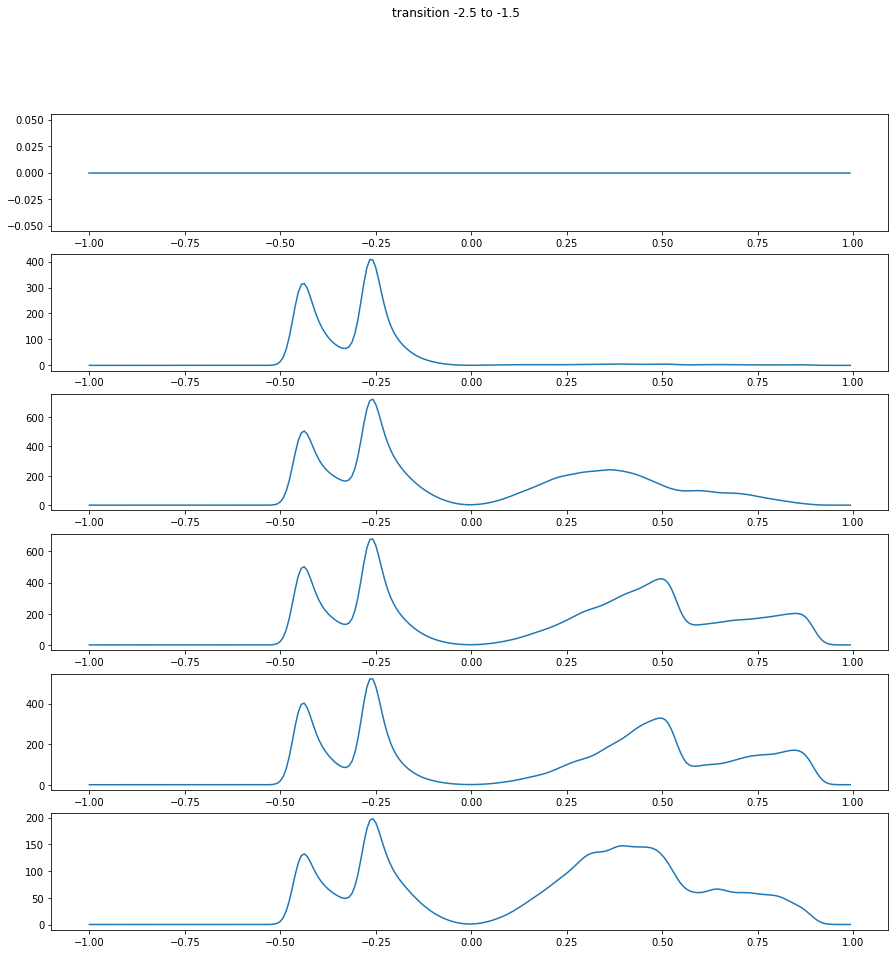

In [6]:

#Nuclear parameters for ENDOR simulation

T = .18                 #gnBngeBe/R3
aiso = 0
Theta = 50             #metal-nuclear vector angle to PAS Z axis
Phi = 0                #metal-nuclear vector off PAS X in PAS XY plane
ELW  = 0.05            # ENDOR linewidth fwhh/MHz
StdFreq = 10.71        #Larmor frequency of nucleus at 1 T (MHz)
                       #1H = 42.57, 2H = 6.54, 13C = 10.71, 15N = 4.314, 14N = 3.074

#PN = (-0.8,-0.4,1.2)             #turning off quadrupole for the moment
#Euler2 = (0,90,45)

#simulation parameters for display
 
SimTransition = 0                 # which of the EPR transitions are calculated 0 = DScalar[0], 1 = DScalar[1]...
Center = True                #Flags for display, Center puts the nuclear larmor frequency at center of X axis
FrC = 0                      # when center = false, the center will be zero. 
Mims = True                 #Include Mims response function to intensities                  
tau = 1.5                  #not used if Mims = False time in microseconds
tau = tau * math.pi
Normalize = True

Output = False
path = "C:/ped/mnsim/"
Fname = "NewIso4A.csv"


#TempCalc = False                 # adjust intensities by Boltzmann
#Temp = 20.0                      # Temperature in Kelvin 
#fact = 1.33e-4                   # boltzmann factor for g=2
#Boltz = np.zeros(NSel)
#for i in range(NSel) :
#    Boltz[i] = math.exp(-BSel[i] *fact / Temp)

Manifold = DScalar[SimTransition]
Cth = Theta*math.pi/180
Pth = Phi*math.pi/180
VDip = (math.cos(Pth)*math.sin(Cth),math.sin(Pth)*math.sin(Cth),math.cos(Cth))    
#Spectral simulation routine. Found it easiest to use large 1-d array 
# rather than create a 2 dimensional array, the spectra are placed in a 1D array with offsets
# essentially, doing the memory calculations myself
#

NFr = 256                       #number of X-axis points

Spec = np.zeros(NFr*NSel)        #allocate and zero arrays
XFr =  np.zeros(NFr)

# ffp First X axis frequency point and lfp last frequency point

ffp = -1.0  
lfp = +1.0

# frequency step for X-axis

dFr = (lfp - ffp)/(NFr)
                
XFr = np.arange(ffp,lfp,dFr)
                


Larmor = []
for b in BSel :
  freq = b * StdFreq / 10000     #13C larmor frequencies for this case
  Larmor.append(freq)  
#
#This loop looks through the orientation selection arrays to match the manifold of interest and then
#calculates the dipolar interaction for any included vector
#
for j in range(3,Ntot) :
    k = ISel[j]
    
    if (MSel[j] == Manifold) :   #selecting the manifold ENDOR to plot. 
        
       ms = (MSel[j] -1) / 2   #convert to ms
       
       na = k * NFr      #array housekeeping            
       bc = Larmor[k] 
       if (Center) : 
        FrC = bc 
        
       V = VSel[j]                       #grab the field direction
       AA = Dipole(VDip, V, T, aiso)      #calculate dipolar 
       BB = 1                            #place holder for intensity without Mims, all intensities are 1
       if (Mims) : 
         BB = math.sin(tau * AA)
         BB = BB*BB                    #calculate Mims endor intensity 
       Plus = abs((ms+1)*AA - bc)        #resonance frequencies plus is simply ms+1, minus is ms
       Minus = abs(ms*AA - bc)
       mp = math.floor( ((Plus-FrC)-ffp) / dFr) 
       if ((mp > 0 ) and (mp < NFr)) : 
        Spec[mp+na]= Spec[mp+na] + BB              #add intensity to correct spectrum at plus/minus
        
       mn = math.floor( ((Minus-FrC)-ffp) / dFr) 
       if((mn > 0) and (mn<NFr)) : 
            Spec[mn+na] = Spec[mn+na] + BB
#            
#The histogram spectra is done tart it up with endor linewidth if desired
#
if(ELW != 0) :
  LW = LWShape(dFr,ELW)                     #convolve endor lineshape function
 
for i in range(0,NSel):
    start = i * NFr
    end = start + NFr
    V = Spec[start:end]
    if(ELW != 0) :
     V = np.convolve(V,LW,'same')          #same is argument that keeps the total X points constant
    Spec[start:end] = V
    

start = []
end = []

for i in range(0,NSel):
    start.append(i*NFr)
    end.append(start[i] + NFr)

    
fig, axs = plt.subplots(NSel,figsize = (15,15))
txt = "transition {lower:.1f} to {upper:.1f}"

fig.suptitle(txt.format(lower = ms, upper = ms+1))
for i in range(0,NSel) :
    axs[i].plot(XFr,Spec[start[i]:end[i]])
    
if (Output == True) :    
 SpPr = np.reshape(Spec,(NFr,NSel),order = 'F')
 df = pd.DataFrame(SpPr,columns = BSel)
 df = df.set_index(XFr)
 df.to_csv(path+Fname)


